In [1]:
"""
  Run this file at first, in order to see what is it printng. Instead of the print() use the respective log level
"""
############################### LOGGER
from abc import ABC, abstractmethod
from logs import *
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
import matplotlib.pyplot as plt


In [2]:
logging.basicConfig
logger = logging.getLogger("MAB Application")


# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

ch.setFormatter(CustomFormatter())

logger.addHandler(ch)

In [3]:
class Bandit(ABC):
    """
    This class is for initializing bandit arms for simulation purposes.

    Parameters:
    p (float): The true probability of winning for the arm.

    Attributes:
    p (float): The inherent probability of winning.
    p_estimate (float): The estimated win rate.
    N (int): The number of trials conducted.

    Methods:
    pull(): Simulate pulling the arm and return the reward.
    update(): Update the win rate estimate based on new data.
    experiment(): Conduct an experiment with multiple trials.
    report(): Generate a detailed report of the experiment outcomes.
    """

    def __init__(self, p):
        """
        Initialize the EpsilonGreedy arm.

        Parameters:
        p (float): The win rate of the arm.
        """
        self.p = p
        self.p_estimate = 0 #estimate of average reward
        self.N = 0
        self.r_estimate = 0 #estimate of average regret

    def __repr__(self):
        """
        Initialize the bandit arm with a specific win probability.
        
        Parameters:
        p (float): The probability of winning.
        """
        return f'An Arm with {self.p} Win Rate'

    @abstractmethod
    def pull(self):
        pass

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def experiment(self):
        pass

    def report(self, N, results, algorithm="Epsilon Greedy"):
        """
        Produce a report containing statistics regarding the experiment.

        Args:
            N (int): Number of trials conducted in the experiment.
            results (tuple): Tuple containing the experiment results.
            algorithm (str): Name of the algorithm utilized.

        Prints:
            Provides statistical analysis and stores data in CSV files.
        """
        if algorithm == 'EpsilonGreedy':
            cumulative_reward_average, cumulative_reward, cumulative_regret, bandits, chosen_bandit, reward, count_suboptimal = results
        else:
            cumulative_reward_average, cumulative_reward, cumulative_regret, bandits, chosen_bandit, reward = results

        # Save experiment data to a CSV file
        data_df = pd.DataFrame({
            'Bandit': [b for b in chosen_bandit],
            'Reward': [r for r in reward],
            'Algorithm': algorithm
        })

        data_df.to_csv(f'{algorithm}_Experiment.csv', index=False)

        # Save Final Results to a CSV file
        data_df1 = pd.DataFrame({
            'Bandit': [b for b in bandits],
            'Reward': [p.p_estimate for p in bandits],
            'Algorithm': algorithm
        })

        data_df1.to_csv(f'{algorithm}_Final.csv', index=False)

        for b in range(len(bandits)):
            print(f'Bandit with True Win Rate {bandits[b].p} - Pulled {bandits[b].N} times - Estimated average reward - {round(bandits[b].p_estimate, 4)} - Estimated average regret - {round(bandits[b].r_estimate, 4)}')
            print("--------------------------------------------------")

        print(f"Cumulative Reward : {sum(reward)}")
        print(" ")
        print(f"Cumulative Regret : {cumulative_regret[-1]}")
        print(" ")
        if algorithm == 'EpsilonGreedy':
            print(f"Percent suboptimal : {round((float(count_suboptimal) / N), 4)}")

# Example usage
# Define your specific bandit implementation inheriting from Bandit class and implement pull and update methods.


In [4]:
class Visualization:
    def plot1(self, N, results, algorithm='EpsilonGreedy'):
        """
        Visualize the algorithm's performance based on cumulative average reward.

        Parameters:
            N (int): Number of trials in the experiment.
            results (tuple): Tuple containing experiment results.
            algorithm (str): Name of the utilized algorithm. Defaults to 'EpsilonGreedy'.

        Prints:
            Linear and logarithmic scale plots illustrating cumulative average reward and optimal reward.
        """

        # Retrieving the bandits and Cumulative Average Reward
        cumulative_reward_average = results[0]
        bandits = results[3]

        ## LINEAR SCALE
        plt.plot(cumulative_reward_average, label='Cumulative Average Reward')
        plt.plot(np.ones(N) * max([b.p for b in bandits]), label='Optimal Reward')
        plt.legend()
        plt.title(f"Win Rate Convergence for {algorithm} - Linear Scale")
        plt.xlabel("Number of Trials")
        plt.ylabel("Estimated Reward")
        plt.show()

        ## LOG SCALE
        plt.plot(cumulative_reward_average, label='Cumulative Average Reward')
        plt.plot(np.ones(N) * max([b.p for b in bandits]), label='Optimal Reward')
        plt.legend()
        plt.title(f"Win Rate Convergence for {algorithm} - Log Scale")
        plt.xlabel("Number of Trials")
        plt.ylabel("Estimated Reward")
        plt.xscale("log")
        plt.show()

    def plot2(self, results_eg, results_ts):
        """
        Compare Epsilon-Greedy and Thompson Sampling regarding cumulative rewards and regrets.

        Parameters:
            results_eg (tuple): Experiment results for Epsilon-Greedy.
            results_ts (tuple): Experiment results for Thompson Sampling.

        Prints:
            Generates plots illustrating the comparison of cumulative rewards and regrets between Epsilon-Greedy and Thompson Sampling.
        """

        # Retrieving Cumulative reward and regret
        cumulative_rewards_eps = results_eg[1]
        cumulative_rewards_th = results_ts[1]
        cumulative_regret_eps = results_eg[2]
        cumulative_regret_th = results_ts[2]

        ## Cumulative Reward
        plt.plot(cumulative_rewards_eps, label='Epsilon-Greedy')
        plt.plot(cumulative_rewards_th, label='Thompson Sampling')
        plt.legend()
        plt.title("Cumulative Reward Comparison")
        plt.xlabel("Number of Trials")
        plt.ylabel("Cumulative Reward")
        plt.show()

        ## Cumulative Regret
        plt.plot(cumulative_regret_eps, label='Epsilon-Greedy')
        plt.plot(cumulative_regret_th, label='Thompson Sampling')
        plt.legend()
        plt.title("Cumulative Regret Comparison")
        plt.xlabel("Number of Trials")
        plt.ylabel("Cumulative Regret")
        plt.show()


In [5]:

class EpsilonGreedy(Bandit):
    
    """
    Epsilon-Greedy multi-armed bandit algorithm.

    This class represents a multi-armed bandit problem solver using the Epsilon-Greedy algorithm.

    Parameters:
    p (float): The true win rate of the arm.

    Attributes:
    p (float): The true win rate of the arm.
    p_estimate (float): The estimated win rate.
    N (int): The number of pulls.

    Methods:
    pull(): Pull the arm and return the sampled reward.
    update(x): Update the estimated win rate with a new reward value.
    experiment(BANDIT_REWARDS, N, t=1): Run the experiment..
    report(N, results): Generate a report with statistics about the experiment.
    """

    def __init__(self, p):
        
        """
        Initialize the EpsilonGreedy arm.

        Parameters:
        p (float): The win rate of the arm.
        """
        super().__init__(p)

    def pull(self):
        
        """
        Pull the arm and return the sampled reward.

        Returns:
        float: The sampled reward from the arm.
        """
        return np.random.randn() + self.p

    def update(self, x):
        
        """
        Update the estimated win rate with a new reward value.

        Parameters:
        x (float): The observed reward.
        """
        self.N += 1.
        self.p_estimate = (1 - 1.0/self.N) * self.p_estimate + 1.0/ self.N * x
        self.r_estimate = self.p - self.p_estimate


    def experiment(self, BANDIT_REWARDS, N, t = 1):
        
        """
        Run the experiment using Epsilon Greedy Algorithm.

        Parameters:
        BANDIT_REWARDS (list): List of true win rates for each arm.
        N (int): The number of Trials.
        t (int): Time step, defaults to 1.

        Returns:
        tuple: A tuple containing average cumulative reward, cumulative reward,  cumulative regret, updated bandits, chosen bandit at each trial, reward at each trial, count of suboptimal pulls
        """
        
        #Initializing Bandits
        bandits = [EpsilonGreedy(p) for p in BANDIT_REWARDS]
        means = np.array(BANDIT_REWARDS)
        true_best = np.argmax(means)  
        count_suboptimal = 0
        EPS = 1/t

        #Keep Track of Which Bandit was chosen and the resulting reward 
        reward = np.empty(N)
        chosen_bandit = np.empty(N)


        for i in range(N):
            p = np.random.random()
            
            if p < EPS:
                j = np.random.choice(len(bandits))
            else:
                j = np.argmax([b.p_estimate for b in bandits])

            x = bandits[j].pull()
            
            bandits[j].update(x)
    

            if j != true_best:
                count_suboptimal += 1
            
            reward[i] = x
            chosen_bandit[i] = j
            
            t+=1
            EPS = 1/t

        cumulative_reward_average = np.cumsum(reward) / (np.arange(N) + 1)
        cumulative_reward = np.cumsum(reward)
        
        cumulative_regret = np.empty(N)
        for i in range(len(reward)):
            cumulative_regret[i] = N*max(means) - cumulative_reward[i]

        return cumulative_reward_average, cumulative_reward,  cumulative_regret, bandits, chosen_bandit, reward, count_suboptimal

In [6]:
class ThompsonSampling(Bandit):
    """
    ThompsonSampling is a class for implementing the Thompson Sampling algorithm for multi-armed bandit problems.

    Attributes:
    - p (float): The win rate of the bandit arm.
    - lambda_ (float): A parameter for the Bayesian prior.
    - tau (float): A parameter for the Bayesian prior.
    - N (int): The number of times the bandit arm has been pulled.
    - p_estimate (float): The estimated win rate of the bandit arm.

    Methods:
    - pull(): Pull the bandit arm and return the observed reward.
    - sample(): Sample from the posterior distribution of the bandit arm's win rate.
    - update(x): Update the bandit arm's parameters and estimated win rate based on the observed reward.
    - plot(bandits, trial): Plot the probability distribution of the bandit arm's win rate after a given number of trials.
    - experiment(BANDIT_REWARDS, N): Run an experiment to estimate cumulative reward and regret for Thompson Sampling.

    """
    
    def __init__(self, p):
        """
        Initialize a ThompsonSampling bandit arm with the given win rate.

        Parameters:
        p (float): The win rate of the bandit arm.
        """
        super().__init__(p)
        self.lambda_ = 1
        self.tau = 1


    def pull(self):
        """
        Pull the bandit arm and return the observed reward.

        Returns:
        float: The observed reward from the bandit arm.
        """
        return np.random.randn() / np.sqrt(self.tau) + self.p
    
    def sample(self):
        """
        Sample from the posterior distribution of the bandit arm's win rate.

        Returns:
        float: The sampled win rate from the posterior distribution.
        """
        return np.random.randn() / np.sqrt(self.lambda_) + self.p_estimate
    
    def update(self, x):
        """
        Update the bandit arm's parameters and estimated win rate based on the observed reward.

        Parameters:
        x (float): The observed reward.
        """
        self.p_estimate = (self.tau * x + self.lambda_ * self.p_estimate) / (self.tau + self.lambda_)
        self.lambda_ += self.tau
        self.N += 1
        self.r_estimate = self.p - self.p_estimate
        
    def plot(self, bandits, trial):
        
        """
        Plot the probability distribution of the bandit arm's win rate after a given number of trials.

        Parameters:
        bandits (list): List of ThompsonSampling bandit arms.
        trial (int): The number of trials or rounds.

        Displays a plot of the probability distribution of the bandit arm's win rate.

        """
        x = np.linspace(-3, 6, 200)
        for b in bandits:
            y = norm.pdf(x, b.p_estimate, np.sqrt(1. / b.lambda_))
            plt.plot(x, y, label=f"real mean: {b.p:.4f}, num plays: {b.N}")
            plt.title("Bandit distributions after {} trials".format(trial))
        plt.legend()
        plt.show()
        
    def experiment(self, BANDIT_REWARDS, N):
        """
        Run an experiment to estimate cumulative reward and regret for Thompson Sampling.

        Parameters:
        BANDIT_REWARDS (list): List of true win rates for each bandit arm.
        N (int): The number of rounds in the experiment.

        Returns:
        tuple: A tuple containing cumulative reward statistics, bandits, and other information.

        """
        
        bandits = [ThompsonSampling(m) for m in BANDIT_REWARDS]

        sample_points = [5, 20, 50,100,200,500,1000,1999, 5000,10000, 19999]
        reward = np.empty(N)
        chosen_bandit = np.empty(N)
        
        for i in range(N):
            j = np.argmax([b.sample() for b in bandits])

            if i in sample_points:
                self.plot(bandits, i)

            x = bandits[j].pull()

            bandits[j].update(x)

            reward[i] = x
            chosen_bandit[i] = j

        cumulative_reward_average = np.cumsum(reward) / (np.arange(N) + 1)
        cumulative_reward = np.cumsum(reward)
        
        cumulative_regret = np.empty(N)
        
        for i in range(len(reward)):
            cumulative_regret[i] = N*max([b.p for b in bandits]) - cumulative_reward[i]


        return cumulative_reward_average, cumulative_reward,  cumulative_regret, bandits, chosen_bandit, reward 
    
def comparison(N, results_eg, results_ts):
    """
    Compare performance of Epsilon Greedy and Thompson Sampling algorithms in terms of cumulative average reward.

    Parameters:
    N (int): The number of trials in the experiment.
    results_eg (tuple): A tuple of Epsilon Greedy experiment results.
    results_ts (tuple): A tuple of Thompson Sampling experiment results.
    
    Prints:
    Linear and log scale plots of cumulative average reward and optimal reward of both algorithms.
    """

    # Retrieving the bandits and Cumulative Average Reward
    cumulative_reward_average_eg = results_eg[0]
    cumulative_reward_average_ts = results_ts[0]
    bandits_eg = results_eg[3]
    reward_eg = results_eg[5]
    reward_ts = results_ts[5]
    regret_eg = results_eg[2][-1]
    regret_ts = results_ts[2][-1]

    print(f"Total Reward Epsilon Greedy : {sum(reward_eg)}")
    print(f"Total Reward Thompson Sampling : {sum(reward_ts)}")
        
    print(" ")
        
    print(f"Total Regret Epsilon Greedy : {regret_eg}")
    print(f"Total Regret Thompson Sampling : {regret_ts}")
        

    plt.figure(figsize=(12, 5))

    # LINEAR SCALE
    plt.subplot(1, 2, 1)
    plt.plot(cumulative_reward_average_eg, label='Cumulative Average Reward Epsilon Greedy')
    plt.plot(cumulative_reward_average_ts, label='Cumulative Average Reward Thompson Sampling')
    plt.plot(np.ones(N) * max([b.p for b in bandits_eg]), label='Optimal Reward')
    plt.legend()
    plt.title(f"Comparison of Win Rate Convergence  - Linear Scale")
    plt.xlabel("Number of Trials")
    plt.ylabel("Estimated Reward")


    plt.subplot(1, 2, 2)
    plt.plot(cumulative_reward_average_eg, label='Cumulative Average Reward Epsilon Greedy')
    plt.plot(cumulative_reward_average_ts, label='Cumulative Average Reward Thompson Sampling')
    plt.plot(np.ones(N) * max([b.p for b in bandits_eg]), label='Optimal Reward')
    plt.legend()
    plt.title(f"Comparison of Win Rate Convergence  - Log Scale")
    plt.xlabel("Number of Trials")
    plt.ylabel("Estimated Reward")
    plt.xscale("log")
    
    
    plt.tight_layout()
    plt.show()

In [7]:
# if __name__=='__main__':
   
#     logger.debug("debug message")
#     logger.info("info message")
#     logger.warning("warning message")
#     logger.error("error message")
#     logger.critical("critical message")

In [8]:
Bandit_Reward = [1, 2, 3, 4]
NumberOfTrials = 20000

In [9]:
#epsilion Greedy

In [10]:
res = EpsilonGreedy(Bandit).experiment(Bandit_Reward, NumberOfTrials)

In [11]:
EpsilonGreedy(Bandit).report(NumberOfTrials, res, algorithm = "EpsilonGreedy")

Bandit with True Win Rate 1 - Pulled 4.0 times - Estimated average reward - 0.671 - Estimated average regret - 0.329
--------------------------------------------------
Bandit with True Win Rate 2 - Pulled 3.0 times - Estimated average reward - 2.3125 - Estimated average regret - -0.3125
--------------------------------------------------
Bandit with True Win Rate 3 - Pulled 3.0 times - Estimated average reward - 3.8916 - Estimated average regret - -0.8916
--------------------------------------------------
Bandit with True Win Rate 4 - Pulled 19990.0 times - Estimated average reward - 3.9991 - Estimated average regret - 0.0009
--------------------------------------------------
Cumulative Reward : 79964.08042298083
 
Cumulative Regret : 35.91957701917272
 
Percent suboptimal : 0.0005


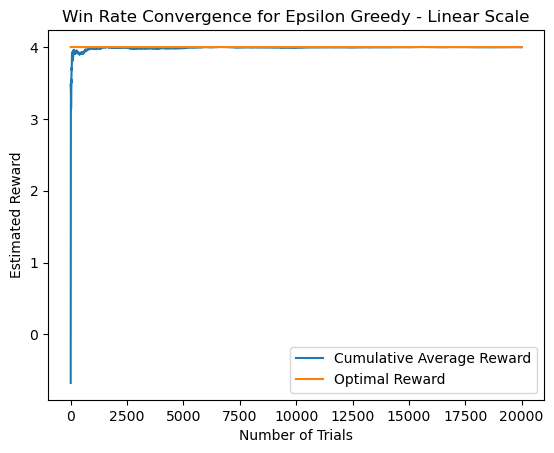

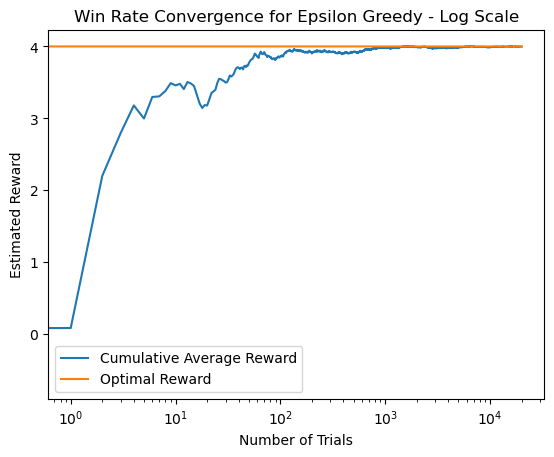

In [12]:
Visualization().plot1(NumberOfTrials, res, 'Epsilon Greedy')


In [13]:
#Thompson Sampling

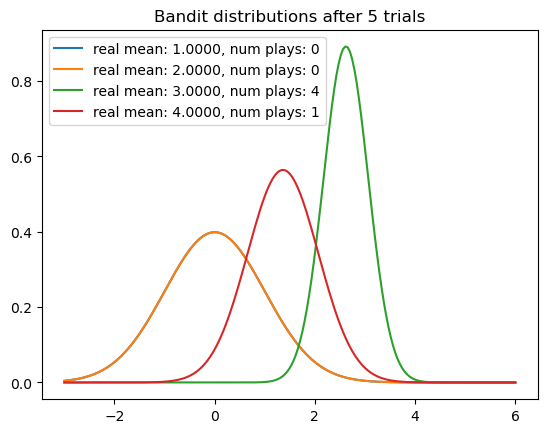

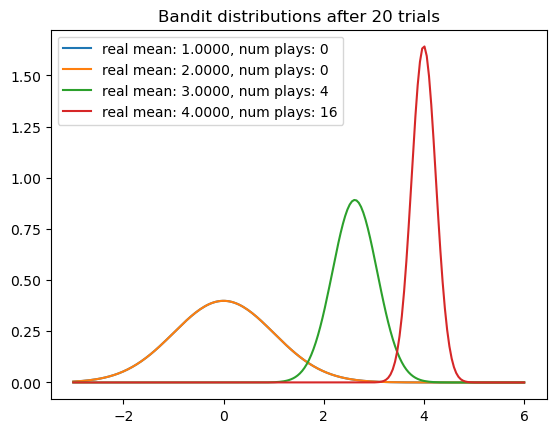

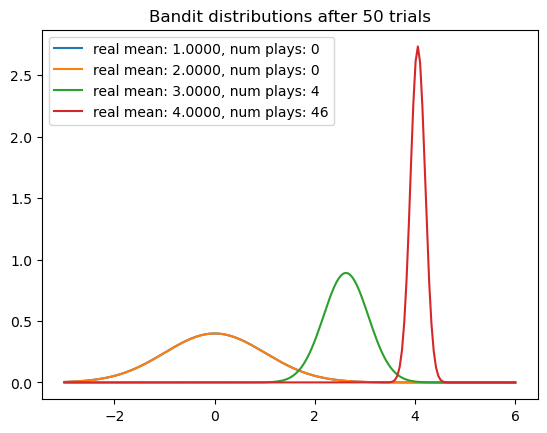

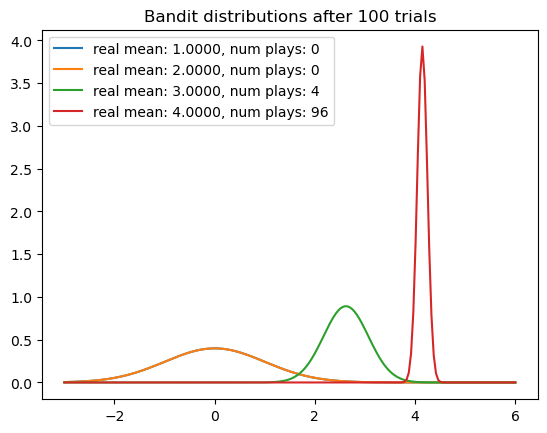

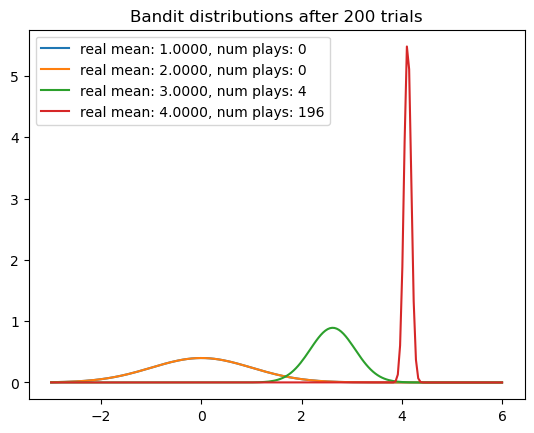

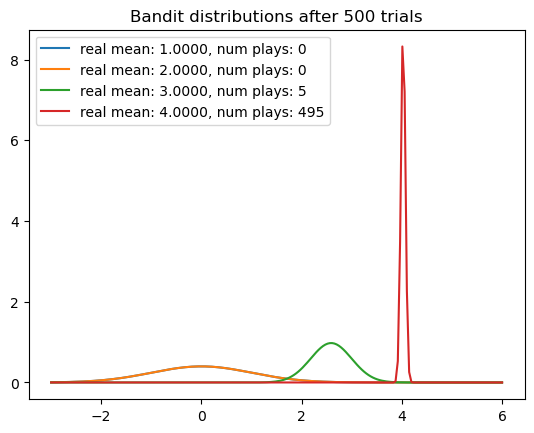

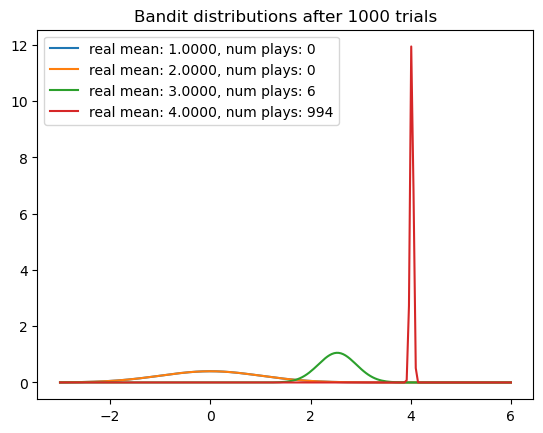

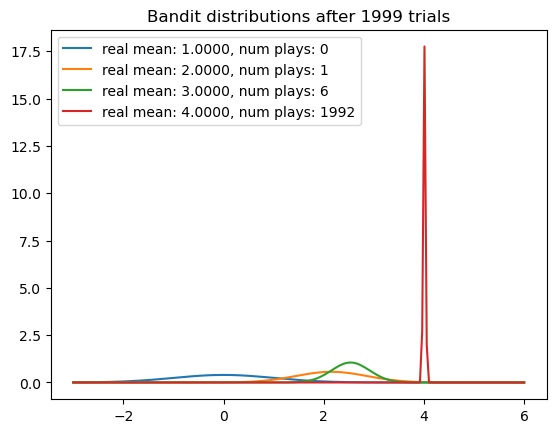

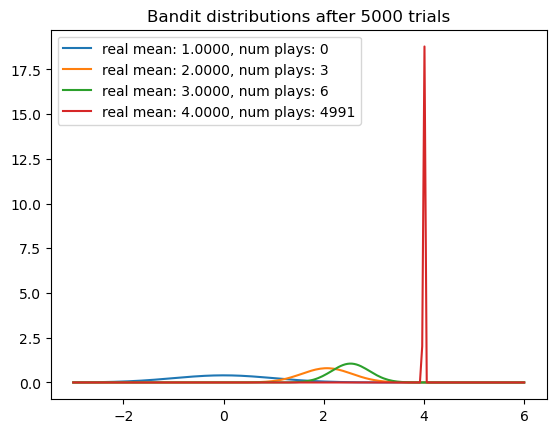

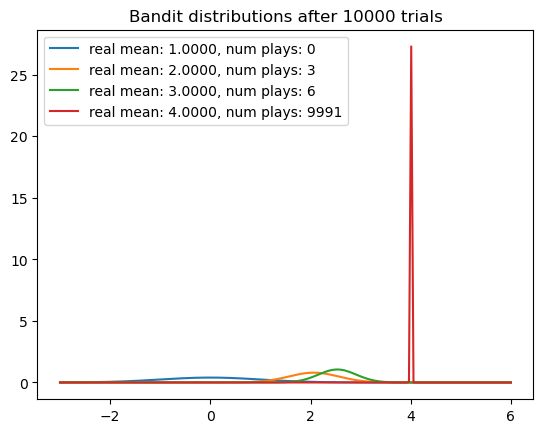

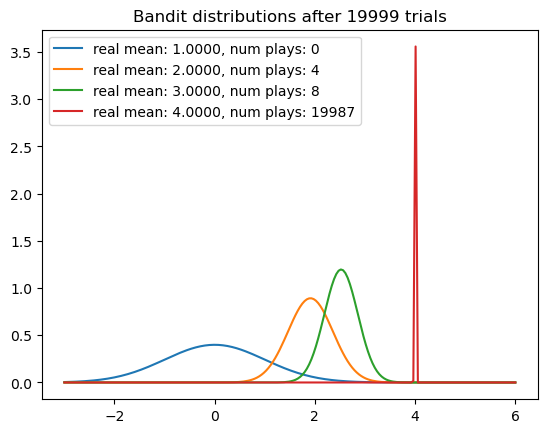

In [14]:
res1 = ThompsonSampling(Bandit).experiment(Bandit_Reward, NumberOfTrials)


In [15]:
ThompsonSampling(Bandit).report(NumberOfTrials, res1, 'ThompsonSampling')


Bandit with True Win Rate 1 - Pulled 0 times - Estimated average reward - 0 - Estimated average regret - 0
--------------------------------------------------
Bandit with True Win Rate 2 - Pulled 4 times - Estimated average reward - 1.9116 - Estimated average regret - 0.0884
--------------------------------------------------
Bandit with True Win Rate 3 - Pulled 8 times - Estimated average reward - 2.5233 - Estimated average regret - 0.4767
--------------------------------------------------
Bandit with True Win Rate 4 - Pulled 19988 times - Estimated average reward - 3.9934 - Estimated average regret - 0.0066
--------------------------------------------------
Cumulative Reward : 79855.68204478986
 
Cumulative Regret : 144.31795521013555
 


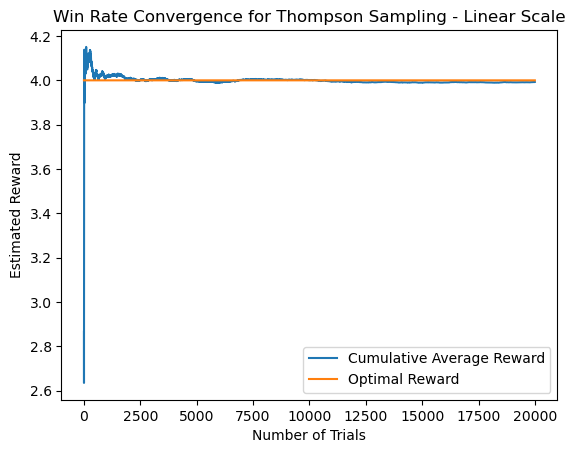

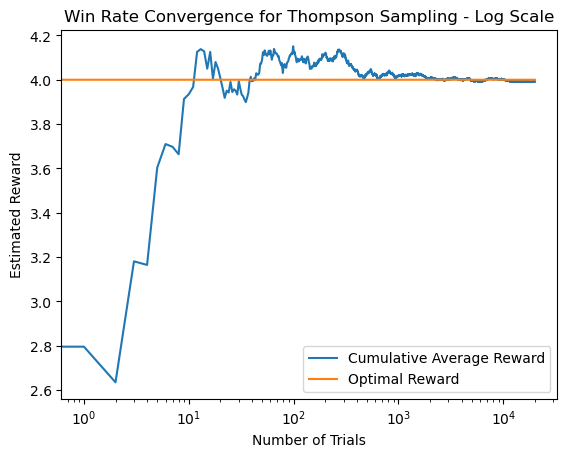

In [16]:
Visualization().plot1( NumberOfTrials,res1, algorithm ='Thompson Sampling')


In [17]:
#comparison of Epsilion Greedy and Thompson Sampling

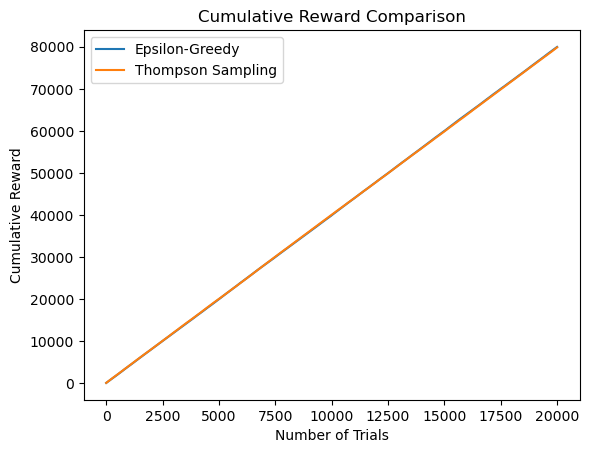

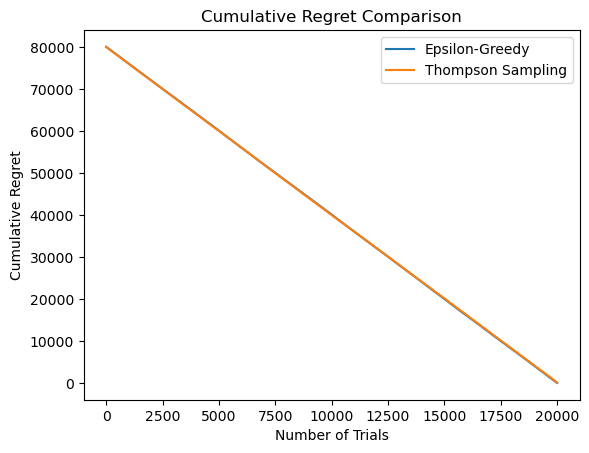

In [18]:
Visualization().plot2(res, res1)

Total Reward Epsilon Greedy : 79964.08042298083
Total Reward Thompson Sampling : 79855.68204478986
 
Total Regret Epsilon Greedy : 35.91957701917272
Total Regret Thompson Sampling : 144.31795521013555


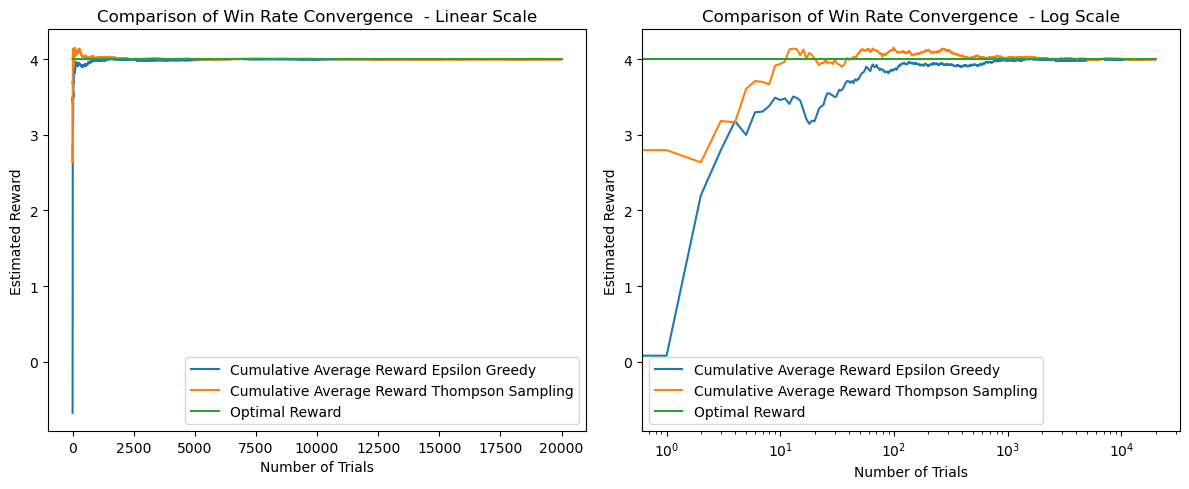

In [19]:
comparison(NumberOfTrials, res, res1)